In [1]:
import os
import pickle as pkl
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from functions import *
import cobra
from cobra.io import read_sbml_model,load_json_model
from cobra import Model, Reaction, Metabolite

In [3]:
model = load_json_model('../data/GSMM_parameters/LP_WCFS1.json')
proB = pd.read_excel('../data/Proteomics/Proteomics_B.xlsx')
gene_info = proB[list(proB.columns[0:5])]
proB = proB[ ['Accession'] + list(proB.columns[-12:])].fillna(0)
uniprot_info = pd.read_csv('../data/Proteomics/uniprotkb_taxonomy_id_220668.tsv',sep='\t')

# Map expression to reactions
* Central carbon metabolism
* Purine and pyrimidine

In [17]:
cc_rxns = ['GLCpts','PGMT','GALU','UDPG4E','MAN6PI','PMANM',
       'PGI','PFK','FBA','TPI','GAPD','PGK','PGM','ENO','PYK',
       'PDH','PTAr','ACKr','PFL','LDH_D','LDH_L','ACCOAC','MACPMT','kaasIII',
       'G6PDH2r','PGL','GND','RPE','RPI','TKT1','TKT2','TALA']

pyr_rxns = ['ASPCT','DHORTS','DHORD6','ORPT','OMPDC','PRPPS',
           'GLUPRT','PRAGS','GARFT','PRFGS','PRAIS','AIRC','PRASCS','ADSL2',
           'AICART','IMPC','IMPD','GMPS2']

In [18]:
def locus2id(locus, uniprot_info):
    temp = uniprot_info[uniprot_info['Gene Names (ordered locus)']==locus] 
    return list(temp['Entry'])[0]
    
    
def get_expr(gene, table, cond):
    if gene not in list(table['Accession']):
        return 0
    temp_pd = (table[table['Accession']==gene]).reset_index().drop(['index'],axis=1)
    expr = sum( [temp_pd[cond+'-B'+str(i)][0] for i in range(1,4) ] )/3
    return expr

def expr_or( gene_list, uniprot_info, expr_table, cond ):
    gids = [ locus2id(x.strip(), uniprot_info) for x in gene_list]
    expr = sum([get_expr(gid, expr_table, cond) for gid in gids])
    return expr

def expr_and( gene_list, uniprot_info, expr_table, cond ):
    gids = [ locus2id(x.strip(), uniprot_info) for x in gene_list]
    expr = min([get_expr(gid, expr_table, cond) for gid in gids])
    return expr

def get_rxn_expr( gpr, uniprot_info, expr_table, cond):
    if '(' not in gpr:
        if 'or' in gpr:
            expr = expr_or( gpr.split('or'), uniprot_info, expr_table, cond )
        else:
            expr = expr_and( gpr.split('and'), uniprot_info, expr_table, cond )
    elif ('(' in gpr) and ('and' in gpr) and ('or' in gpr): # for GLCpts/AIRC special case
        gpr_list = gpr.split('or')
        expr_1 = expr_and( gpr_list[0].replace('(','').replace(')','').split('and'), uniprot_info, expr_table, cond )
        expr_2 = expr_and( gpr_list[1].replace('(','').replace(')','').split('and'), uniprot_info, expr_table, cond )
        expr = expr_1 + expr_2
    elif ('(' in gpr) and ('and' in gpr):
        gpr = gpr.replace('(','').replace(')','')
        expr = expr_and( gpr.split('and'), uniprot_info, expr_table, cond )
        
    return expr  

In [19]:
data = []
for rxn_id in cc_rxns:
    temp = {'RXN':rxn_id}
    gpr = model.reactions.get_by_id( rxn_id ).gene_reaction_rule
    for cond in ['pH6.5','pH5.5','pH5','pH4.5']:
        expr = get_rxn_expr( gpr, uniprot_info, proB, cond)
        temp[cond] = expr
    data.append(temp)
    
cc_rxn_expr = pd.DataFrame(data)
idx_keep = cc_rxn_expr.index[ cc_rxn_expr[cc_rxn_expr.columns[1:5]].sum(axis=1)>0 ]
cc_rxn_expr = (cc_rxn_expr.iloc[idx_keep]).reset_index().drop(['index'],axis=1)

for acid_cond in ['pH5.5','pH5','pH4.5']:
    cc_rxn_expr[ 'Log2FC_'+ acid_cond + 'vsRef' ] = list( np.log2( cc_rxn_expr[acid_cond]/cc_rxn_expr['pH6.5'] ) )
# cc_rxn_expr.to_csv('../data/Proteomics/cc_RXN_lfc.csv',index=None)

In [20]:
data = []
for rxn_id in pyr_rxns:
    temp = {'RXN':rxn_id}
    gpr = model.reactions.get_by_id( rxn_id ).gene_reaction_rule
    for cond in ['pH6.5','pH5.5','pH5','pH4.5']:
        expr = get_rxn_expr( gpr, uniprot_info, proB, cond)
        temp[cond] = expr
    data.append(temp)
pyr_rxn_expr = pd.DataFrame(data)
for acid_cond in ['pH5.5','pH5','pH4.5']:
    pyr_rxn_expr[ 'Log2FC_'+ acid_cond + 'vsRef' ] = list( np.log2( pyr_rxn_expr[acid_cond]/pyr_rxn_expr['pH6.5'] ) )
# pyr_rxn_expr.to_csv('../data/Proteomics/pyr_RXN_lfc.csv' ,index=None)

# RA relations: re-scale protein expression to mass ratio

In [12]:
sectors = {'C':[],'T':[],'A':[],'EPS_syn':[]}
sectors['T'] = ['F9UST3', 'F9UR54','F9UN59','F9UN60'] # lactic acid transporter, GLCpts, 

In [13]:
for i in range(len(gene_info.index) ):
    if 'ribosomal subunit protein' in list(gene_info['Protein Name'])[i] \
            or 'ribosomal protein' in list(gene_info['Protein Name'])[i] :
        sectors['A'].append( list(gene_info['Accession'])[i].strip() )

In [14]:
column_names = ('query acc.ver, subject acc.ver, % identity, alignment length, mismatches, gap opens, q. start, q. end, s. start, s. end, evalue, bit score').split(', ')
data = []
ffile = open('../data/Genome_HMX2/eps_blast_uniprot.tsv', "rt")
lines = ffile.readlines()
ffile.close()
for line in lines:
    line = line.strip()
    if '#' not in line:
        data.append( line.split('\t'))
blast_result = pd.DataFrame(data ,columns=column_names)
sectors['EPS_syn'] = list( set(blast_result['subject acc.ver']).intersection(set(list(gene_info['Accession']))) )

In [21]:
sector_expr = []
temp = cc_rxn_expr.iloc[1:,1:5]
c_expr = dict( temp.sum(axis=0) )
c_expr['sector'] = 'C'
sector_expr.append( c_expr )

for sec in ['T','A','EPS_syn']:
    data = {'sector':sec}
    for cond in ['pH6.5','pH5.5','pH5','pH4.5']:
        expr = 0
        for gene in sectors[sec]:
            expr += get_expr(gene, proB, cond)
        data[cond] = expr
    sector_expr.append(data)
sec_expr_table = pd.DataFrame(sector_expr)

Text(0, 0.5, 'U/(A+C+T+U)')

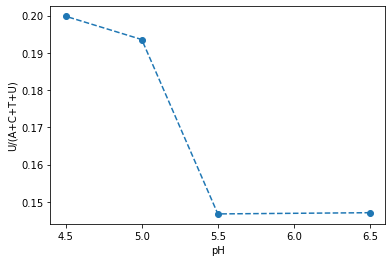

In [43]:
u_ratio = []
for i in range(4):
    u_ratio.append( sec_expr_table.iloc[3,i]/sum(sec_expr_table.iloc[:,i])  )
plt.plot([6.5,5.5,5.0,4.5],u_ratio, marker='o',linestyle='--')
plt.xticks([4.5,5.0,5.5,6.0,6.5]);
plt.xlabel('pH')
plt.ylabel('U/(A+C+T+U)')